In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
LABELS = ["Normal","Fraud"]

In [3]:
dataset = pd.read_csv("creditcard.csv")
dataset['V1'].min()

-56.407509631329

In [4]:
#check for any  nullvalues 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0 1]
-------
Break down of the Normal and Fraud Transactions
Class
0    284315
1       492
Name: count, dtype: int64


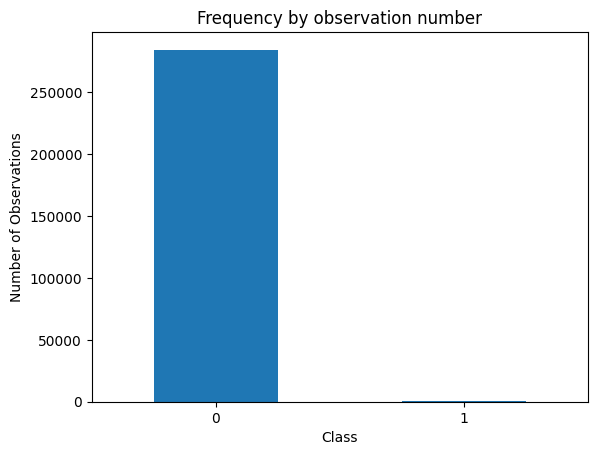

In [5]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

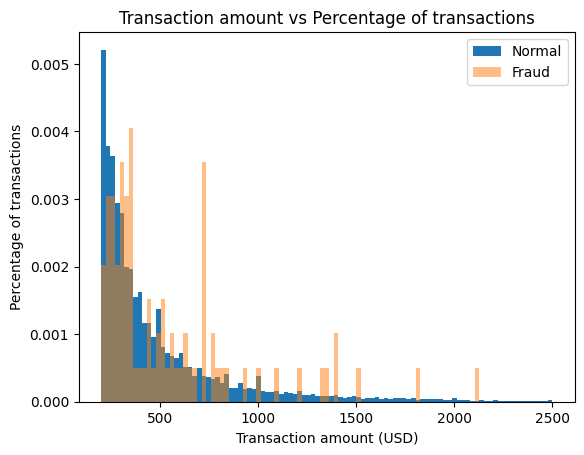

In [6]:
# Save the normal and fradulent transactions in separate dataframe
normal_dataset = dataset[dataset.Class == 0] 
fraud_dataset = dataset[dataset.Class == 1]
#Visualize transactionamounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100) # Return evenly spaced numbers over a specified interval.
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

In [7]:
'''Time and Amount are the columns that are not scaled, so applying StandardScaler to only Amount and Time columns. 
Normalizing the values between 0 and 1 did not work great for the dataset.'''

'Time and Amount are the columns that are not scaled, so applying StandardScaler to only Amount and Time columns. \nNormalizing the values between 0 and 1 did not work great for the dataset.'

In [8]:
sc=StandardScaler()
print(dataset['Time'])
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64


In [9]:
dataset['Time']

0        -1.996583
1        -1.996583
2        -1.996562
3        -1.996562
4        -1.996541
            ...   
284802    1.641931
284803    1.641952
284804    1.641974
284805    1.641974
284806    1.642058
Name: Time, Length: 284807, dtype: float64

In [10]:
train_x, test_x = train_test_split(dataset, test_size=0.3, random_state=42)

train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class'] # save the class column for the test set

test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray
train_x

array([[-1.95225609e+00, -2.28956540e+00, -4.80259812e-01, ...,
         3.92241265e-01, -1.47756654e-01, -3.49231307e-01],
       [ 1.24006197e+00, -3.13716788e-01, -4.06434174e+00, ...,
        -2.90331333e-01,  1.10360002e-01,  4.42160499e+00],
       [ 5.19949707e-02, -1.80976314e+00, -5.67439077e-01, ...,
        -6.23851804e-02,  8.80786484e-02, -5.33729284e-02],
       ...,
       [-3.16265999e-01, -1.46608925e-01,  9.92946123e-01, ...,
        -1.21139194e-01, -1.96195328e-01, -3.37476933e-01],
       [-1.44938732e-01, -2.94863809e+00,  2.35484929e+00, ...,
         4.96912107e-01,  3.35821632e-01, -3.49231307e-01],
       [-3.88157751e-01,  1.23317435e+00, -7.84850501e-01, ...,
         1.21657270e-03,  3.85878912e-02,  9.85543469e-02]])

#### Autoencoder Layer Structure and Parameters
Autoencoder has symmetric encoding and decoding layers that are "dense". We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, I am encoding 30 columns into 14 dimensions so I am expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [11]:
nb_epoch = 50
batch_size = 64
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

In [12]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                
                        activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
# encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
# decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             434 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │              35 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │             450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168 (4.56 KB)

 Trainable params: 1,168 (4.56 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
"""Define the callbacks for checkpoints and early stopping"""

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.keras",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [14]:
#Compile the Autoencoder

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [15]:
#Train the Autoencoder

history = autoencoder.fit(train_x, train_x,
                    epochs=10,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history
.63



Epoch 1/10
3071/3110 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.3153 - loss: 0.8797
Epoch 1: val_loss improved from inf to 0.75110, saving model to autoencoder_fraud.keras
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.3163 - loss: 0.8786 - val_accuracy: 0.4276 - val_loss: 0.7511
Epoch 2/10
3075/3110 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.4209 - loss: 0.7440
Epoch 2: val_loss improved from 0.75110 to 0.73315, saving model to autoencoder_fraud.keras
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4209 - loss: 0.7438 - val_accuracy: 0.4079 - val_loss: 0.7332
Epoch 3/10
3072/3110 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.4082 - loss: 0.7086
Epoch 3: val_loss improved from 0.73315 to 0.72107, saving model to autoencoder_fraud.keras
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4082 - loss: 0.7086 - val_accuracy: 0.4078 - val_loss: 0.7211
Epoch 4/10
3070/3110 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.4049 - loss: 0.7063
Epoch 4: va

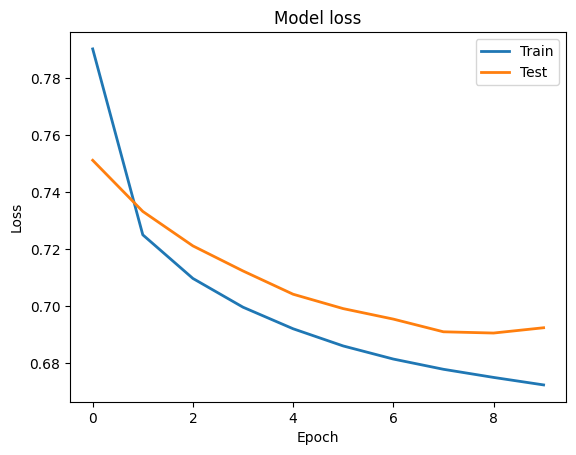

In [16]:
#Plot training and test loss

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [17]:
"""Detect Anomalies on test data

Anomalies are data points where the reconstruction loss is higher

To calculate the reconstruction loss on test data, 
predict the test data and calculate the mean square error between the test data and the reconstructed test data."""

test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 2s 693us/step


,Reconstruction_error,True_class
count,85443.000000,85443.000000
mean,0.690470,0.001592
std,3.366722,0.039865
min,0.029731,0.000000
25%,0.191973,0.000000
50%,0.312277,0.000000
75%,0.564981,0.000000
max,252.698594,1.000000


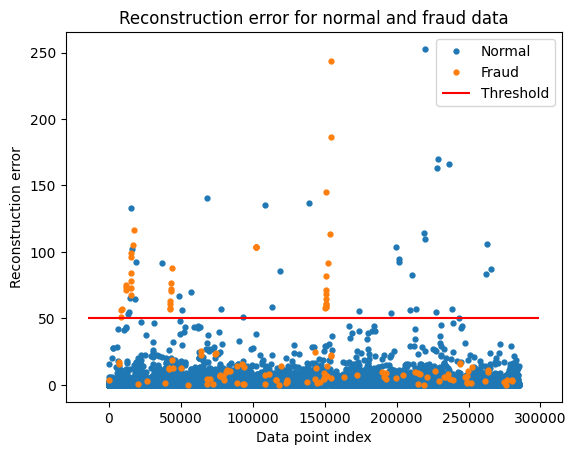

In [18]:
#Plotting the test data points and their respective reconstruction error sets a threshold value to visualize 
#if the threshold value needs to be adjusted.

threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

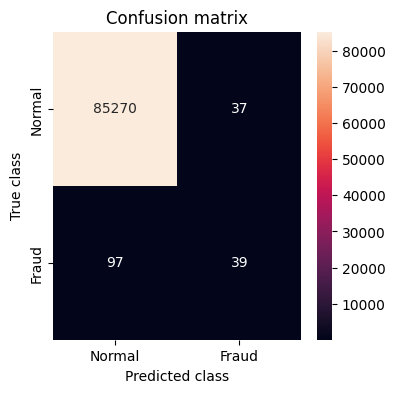

 Accuracy:  0.9984317030066828
 Recall:  0.2867647058823529
 Precision:  0.5131578947368421


In [19]:
'''Detect anomalies as points where the reconstruction loss is greater than a fixed threshold. 
Here we see that a value of 52 for the threshold will be good.

Evaluating the performance of the anomaly detection'''
import seaborn as sns

threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

In [20]:
'''As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.

Things to further improve precision and recall would add more relevant features, 
different architecture for autoencoder, different hyperparameters, or a different algorithm.'''

'As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.\n\nThings to further improve precision and recall would add more relevant features, \ndifferent architecture for autoencoder, different hyperparameters, or a different algorithm.'